In [4]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [14, 6]
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from biosppy.signals import ecg
#
from hrv.classical import time_domain
from hrv.classical import frequency_domain
from hrv.classical import non_linear
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from joblib import dump, load


In [5]:
data1 = np.load("1.npy")
data2 = np.load("2.npy")
data3 = np.load("3.npy")
data4 = np.load("4.npy")
data5 = np.load("5.npy")
print(data1.shape)
print(data2.shape)
print(data3.shape)
print(data4.shape)
print(data5.shape)

(833, 10801)
(1253, 10801)
(902, 10801)
(935, 10801)
(1105, 10801)


In [6]:
def hrvAnalysis(NN):
    diffNN = np.absolute(np.diff(NN))
    L = len(NN)    
    ANN = np.mean(NN)
    SDNN = np.std(NN)
    SDSD = np.std(diffNN)    
    #NN50 = len(np.where(np.diff(NN) > 0.05)[0])    
    NN50 = diffNN[diffNN > 0.05].size
    pNN50 = NN50/(L - 1)    
    rMSSD = np.sqrt(1/(L-1) * sum(diffNN ** 2))        
    rangeNum = np.ptp(NN)
    
    #non linear: pointcare & entropy
    #pointcare
    sd1, sd2 = poincare(NN)
    #entropy
    prob_NN = NN / NN.sum()
    shannon = -np.sum(prob_NN*np.log2(prob_NN))
    
    
    timeDomainFeats = {'ANN': ANN, 'SDNN': SDNN,
                       'pNN50': pNN50, 'rMSSD':rMSSD, 'sd1': sd1, 'sd2': sd2, 'shannon': shannon}
                       
    return timeDomainFeats

def poincare(rri):
    diff_rri = np.absolute(np.diff(rri))
    sd1 = np.sqrt(np.std(diff_rri, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(rri, ddof=1) ** 2 - 0.5 * np.std(diff_rri,
                                                              ddof=1) ** 2)
    return sd1, sd2

def cal_r_peaks(signal, sampling_rate):
    """
    """
    rpeaks, = ecg.hamilton_segmenter(signal=signal,
                                     sampling_rate=sampling_rate)
    rpeaks, = ecg.correct_rpeaks(signal=signal,
                                 rpeaks=rpeaks,
                                 sampling_rate=sampling_rate,
                                 tol=0.05)
    templates, rpeaks = ecg.extract_heartbeats(signal=signal,
                                               rpeaks=rpeaks,
                                               sampling_rate=sampling_rate,
                                               before=0.2,
                                               after=0.4)
    return rpeaks

def create_features(raw_data, fs):
    """
    """
    data  = raw_data[:, :-1]
    label = raw_data[:, -1]

    result = []
    for x in data:
        rpeaks = cal_r_peaks(x, fs)
        tmp = np.diff(rpeaks)
        rri = tmp * 1.0 / fs

        time = hrvAnalysis(rri)
        result.append(list(time.values()))
        
    result = np.array(result)
    return result, label

def train(training_data, testing_data, training_label, testing_label, hidden_layer, activation):
    
    #model
    model = MLPClassifier(solver='lbfgs', alpha=5e-3, activation = activation, hidden_layer_sizes=(hidden_layer), learning_rate_init=0.001, max_iter=400)
    model.fit(X=training_data, y=training_label)
    prediction = model.predict(testing_data)
    accuracy = accuracy_score(prediction, testing_label)
    loss = model.loss_
    iteration = model.n_iter_
    return accuracy, loss, iteration

def kfold(d1, d2, d3, d4, d5, l1, l2, l3, l4, l5, hidden_layer, activation):
    #fold 1
    training1 = np.concatenate((d2, d3, d4, d5), 0)
    training_label1 = np.concatenate((l2, l3, l4, l5), 0)
    accuracy1, loss1, iteration1 = train(training1, d1, training_label1, l1, hidden_layer, activation)
    #print("accuracy:", accuracy1, "loss", loss1, "iteration", iteration1)
    #end

    #fold 2
    training2 = np.concatenate((d1, d3, d4, d5), 0)
    training_label2 = np.concatenate((l1, l3, l4, l5), 0)
    accuracy2, loss2, iteration2 = train(training2, d2, training_label2, l2, hidden_layer, activation)
    #print("accuracy:", accuracy2, "loss", loss2, "iteration", iteration2)
    #end

    #fold 3
    training3 = np.concatenate((d2, d1, d4, d5), 0)
    training_label3 = np.concatenate((l2, l1, l4, l5), 0)
    accuracy3, loss3, iteration3 = train(training3, d3, training_label3, l3, hidden_layer, activation)
    #print("accuracy:", accuracy3, "loss", loss3, "iteration", iteration3)
    #end

    #fold 4
    training4 = np.concatenate((d2, d3, d1, d5), 0)
    training_label4 = np.concatenate((l2, l3, l1, l5), 0)
    accuracy4, loss4, iteration4 = train(training4, d4, training_label4, l4, hidden_layer, activation)
    #print("accuracy:", accuracy4, "loss", loss4, "iteration", iteration4)
    #end

    #fold 5
    training5 = np.concatenate((d2, d3, d4, d1), 0)
    training_label5 = np.concatenate((l2, l3, l4, l1), 0)
    accuracy5, loss5, iteration5 = train(training5, d5, training_label5, l5, hidden_layer, activation)
    #print("accuracy:", accuracy5, "loss", loss5, "iteration", iteration5)
    #end
    accuracy_average = (accuracy1 + accuracy2 + accuracy3 + accuracy4 + accuracy5)/5
    return accuracy_average

def modelSelection(list_activation, list_hidden, d1, d2, d3, d4, d5):
    
    #create features
    training1, label1 = create_features(d1, 360)
    training2, label2 = create_features(d2, 360)
    training3, label3 = create_features(d3, 360)
    training4, label4 = create_features(d4, 360)
    training5, label5 = create_features(d5, 360)
    
    best_activation = ""
    g_accuracy = 0.1
    best_hidden = list_hidden[0]
    i = 0
    for activation in list_activation:
        for hidden_layer in list_hidden:
            accuracy = kfold(training1, training2, training3, training4, training5, label1, label2, label3, label4, label5, hidden_layer, activation)
            i = i+1
            if(accuracy > g_accuracy):
                print("ith: ", i, "accuracy: ", accuracy, "hidden_layer", hidden_layer, "activation: ", activation)
                g_accuracy = accuracy
                best_hidden = hidden_layer
                best_activation = activation
    return g_accuracy, best_hidden, best_activation
                

In [7]:
#init the potential parameter - hidden layer
B = np.linspace(15, 25, 11, dtype=int)
C = np.append(B, B.T, axis = 0)
D = C.reshape((2, 11))
A2 = D.T
B = B.reshape((11,1))
A3 = np.append(A2, B, axis = 1)
A4 = np.append(A3, B, axis = 1)

#init activation
list_activation = ['logistic', 'tanh', 'relu']

In [8]:
#model selection
g_loss1, best_hidden1, best_activation1 = modelSelection(list_activation, A2, data1, data2, data3, data4, data5)
print("g_acc1: ", g_loss1, " best_hiddent1: ", best_hidden1, "best_activation1:", best_activation1)

g_loss2, best_hidden2, best_activation2 = modelSelection(list_activation, A3, data1, data2, data3, data4, data5)
print("g_acc2: ", g_loss2, " best_hiddent2: ", best_hidden2, "best_activation2:", best_activation2)

g_loss3, best_hidden3, best_activation3 = modelSelection(list_activation, A4, data1, data2, data3, data4, data5)
print("g_acc3: ", g_loss3, " best_hiddent3: ", best_hidden3, "best_activation3:", best_activation3)

g_loss4, best_hidden4, best_activation4 = modelSelection(list_activation, B, data1, data2, data3, data4, data5)
print("g_acc4: ", g_loss4, " best_hiddent4: ", best_hidden4, "best_activation4:", best_activation4)

ith:  1 accuracy:  0.7328463121608755 hidden_layer [15 15] activation:  logistic
ith:  2 accuracy:  0.7987466594305159 hidden_layer [16 16] activation:  logistic
ith:  4 accuracy:  0.8112515112126261 hidden_layer [18 18] activation:  logistic
ith:  10 accuracy:  0.8150222395859782 hidden_layer [24 24] activation:  logistic
ith:  24 accuracy:  0.8356642173409508 hidden_layer [16 16] activation:  relu
g_acc1:  0.8356642173409508  best_hiddent1:  [16 16] best_activation1: relu
ith:  1 accuracy:  0.7851606335064687 hidden_layer [15 15 15] activation:  logistic
ith:  2 accuracy:  0.8094596291917842 hidden_layer [16 16 16] activation:  logistic
ith:  8 accuracy:  0.831338918174988 hidden_layer [22 22 22] activation:  logistic
g_acc2:  0.831338918174988  best_hiddent2:  [22 22 22] best_activation2: logistic
ith:  1 accuracy:  0.5644459067962144 hidden_layer [15 15 15 15] activation:  logistic
ith:  12 accuracy:  0.7562659977914958 hidden_layer [15 15 15 15] activation:  tanh
ith:  13 accuracy

In [9]:
#the best architechture: (23), activation: relu

#training with all data and the best architechture
all_data = np.concatenate((data1, data2, data3, data4, data5), 0)

all_training_data, all_label_data = create_features(all_data, 360)

#scaled data
scaler = StandardScaler()
scaler.fit(all_training_data)
scaled_training_features = scaler.transform(all_training_data)
    
#model
model = MLPClassifier(solver='lbfgs', alpha=5e-3, activation = "relu", hidden_layer_sizes=(23), learning_rate_init=0.01, max_iter=400)
model.fit(X=scaled_training_features, y=all_label_data)
loss = model.loss_
iteration = model.n_iter_


In [10]:
#save the model
dump(model, 'model.pkl')

['model.pkl']

In [39]:
#load the model
clf = load('model.pkl')

In [40]:
#testing data
test_data = np.load('test_data.npy')
testing_data, testing_label = create_features(test_data, 360)

#scaled data
scaler = StandardScaler()
scaler.fit(testing_data)
scaled_testing_features = scaler.transform(testing_data)

#predict & assesment
pred = clf.predict(scaled_testing_features)


In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

test_accuracy = accuracy_score(testing_label, pred)
confusion_matrix = confusion_matrix(testing_label, pred)
print("testing accuracy: ", test_accuracy)
print("confusion matrix: ")
print(confusion_matrix)
print("---------------------------------------------------------------")
p_0 = 322/(322 + 48 + 49)
p_1 = 188/(188 + 2 + 22)
p_2 = 97/(97 + 27 + 9)
print("precision for label 0: ", p_0)
print("precision for label 1: ", p_1)
print("precision for label 2: ", p_2)

print("---------------------------------------------------------------")
f1_0 = 322/(322 + 2 + 9)
f1_1 = 188/(188+48+27)
f1_2 = 97/(97+22+49)

print("f1 score for label 0: ", f1_0)
print("f1 score for label 1: ", f1_1)
print("f1 score for label 2: ", f1_2)

testing accuracy:  0.7945026178010471
confusion matrix: 
[[322   2   9]
 [ 48 188  27]
 [ 49  22  97]]
---------------------------------------------------------------
precision for label 0:  0.7684964200477327
precision for label 1:  0.8867924528301887
precision for label 2:  0.7293233082706767
---------------------------------------------------------------
f1 score for label 0:  0.9669669669669669
f1 score for label 1:  0.714828897338403
f1 score for label 2:  0.5773809523809523


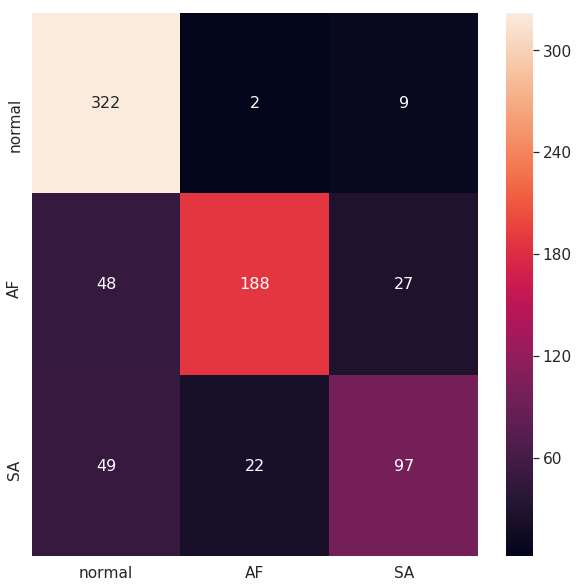

In [55]:
#visualize confusion matrix
df_cm = pd.DataFrame(confusion_matrix, index = ['normal','AF','SA'],
                  columns = ['normal','AF','SA'])
plt.figure(figsize = (10,10))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,fmt="d",annot_kws={"size": 16})# font size